# Домашнее задание 6

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 24 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_6

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{2}x^T A x - b^T x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица с $L =1000$, $\mu = 1$, $d = 100$, $b$ - так же случайный вектор.

__(а)__ Для такой задачи симулируем итерацию координатного спуска (смотри семинар). 

Для такого метода подберите шаг $\gamma$ для наилучшей сходимости постройте график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число арифмитических операций при подсчете "градиента"). Постройте на этом же графике сходимость честного градиентного спуска c наилучшим шагом сходимости. Сделайте вывод о характере сходимости нового метода.

In [294]:
import numpy as np
import scipy.linalg as la
import math
import matplotlib.pyplot as plt
import time
import random

In [284]:
# m >= 0, L >= m
def generate(d = 3, m = 1, L = 5):

    # сгенерируем диагональную матрицу по собственным числам
    if d == 1:
        lambdas = [m]
    if d == 2:
        lambdas = [m, L]
    if d > 2:
        lambdas = np.random.uniform(low=m, high=L, size=(d-2,))
        lambdas = lambdas.tolist() + [m, L]

    A = np.diag(lambdas)
    q, _ = la.qr(np.random.rand(d, d))
    A = q.T @ A @ q
    b = np.random.uniform(low=-L/10, high=L/10, size=(d,))

    return A, b

In [285]:
d = 100
mu = 1
L = 1000
A, b = generate(d, mu, L)
x0 = np.random.uniform(low=-L/20, high=L/20, size=(d,))

In [286]:
def f(x):
    return 0.5 * x.T @ A @ x - b.T @ x

def grad(x):
    return A @ x - b

In [287]:
def err_gradnorm(x):
    return np.linalg.norm(grad(x), ord=2)**2

In [288]:
def risovach(times, errs, labels):

    plt.figure(figsize=(9, 6))
    for g, l in zip(errs, labels):
        plt.plot(range(len(g)), np.log(g), label=l)
    plt.xlabel("Номер итерации")
    plt.ylabel("Логарифм критерия")
    plt.title('График по итерациям')
    plt.legend(fontsize=12)
    plt.show()

    plt.figure(figsize=(9, 6))
    for t, g, l in zip(times, errs, labels):
        plt.plot(t, np.log(g), label=l)
    plt.xlabel("Прошедшее время")
    plt.ylabel("Логарифм критерия")
    plt.title('График по времени')
    plt.legend(fontsize=12)
    plt.show()

In [289]:
def gd_fast(x0, error=err_gradnorm, iters=1000, eps=1e-9):
    x = x0
    x_vals = [x]
    f_vals = [f(x)]
    times = [0.]
    errs = [error(x)]

    start = time.time()

    for i in range(1, iters):
        
        g = grad(x)
        gamma = (g.T @ g) / (g.T @ A @ g)
        x = x - gamma * g

        x_vals.append(x)
        f_vals.append(f(x))
        times.append(time.time() - start)
        errs.append(error(x))

        if error(x) < eps:
            break

    return x_vals, f_vals, times, errs

In [328]:
def stoch_grad(x, batch=1):
    g = np.zeros((d,))
    a = random.sample(range(0, d), batch)
    for i in a:
        g[i] = 1/2 * (A[i] + A.T[i]) @ x - b[i]
    return g

def csgd(x0, gamma, error=err_gradnorm, batch=1, iters=1000, eps=1e-9):
    x = x0
    x_vals = [x]
    f_vals = [f(x)]
    times = [0.]
    errs = [np.linalg.norm(grad(x), ord=2)**2]

    start = time.time()

    for i in range(1, iters):
        
        g = stoch_grad(x, batch)
        x = x - gamma * d * g

        x_vals.append(x)
        f_vals.append(f(x))
        times.append(time.time() - start)
        err = error(x)
        errs.append(err)

        if err < eps:
            break

    return x_vals, f_vals, times, errs

In [329]:
iters = 10000
x_, f_, times_, errs_ = gd_fast(x0=x0, error=err_gradnorm, iters=iters)
x1, f1, times1, errs1 = csgd(x0=x0, gamma=65/(L*d), error=err_gradnorm, batch=1, iters=iters)

/tmp/ipykernel_7361/748225756.py:2: RuntimeWarning: overflow encountered in matmul
  return 0.5 * x.T @ A @ x - b.T @ x
/tmp/ipykernel_7361/748225756.py:2: RuntimeWarning: invalid value encountered in matmul
  return 0.5 * x.T @ A @ x - b.T @ x
/tmp/ipykernel_7361/748225756.py:5: RuntimeWarning: overflow encountered in matmul
  return A @ x - b
/tmp/ipykernel_7361/748225756.py:5: RuntimeWarning: invalid value encountered in matmul
  return A @ x - b


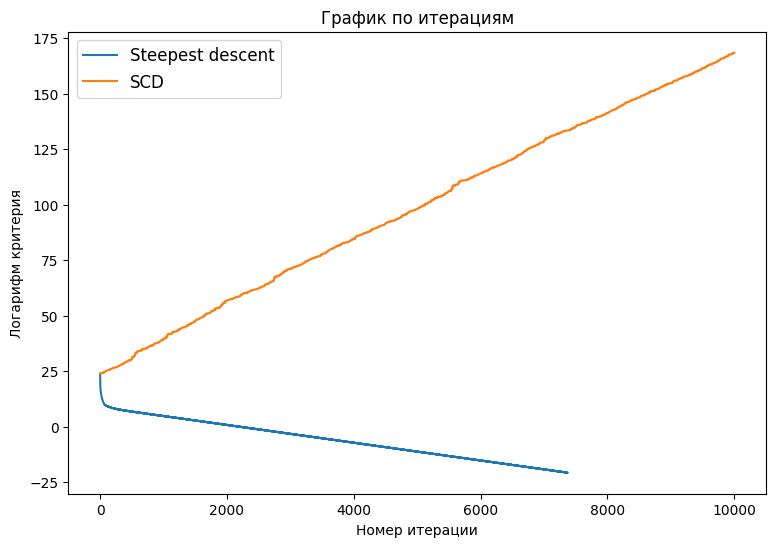

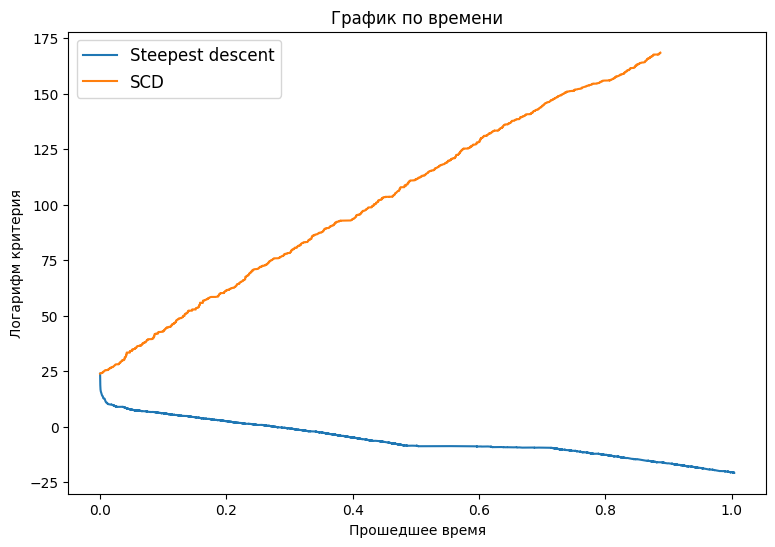

In [325]:
risovach(times=[times_, times1], errs=[errs_, errs1], labels=[r'Steepest descent', r'SCD'])

Выше был реализован простейший координатный спуск, который на каждой итерации спускается по одной случайной координате. Сходится он крайне медленно...

__(б)__ В координатном спуске можно брать несколько координат вместо одной. Модифицируйте координнатный спуск, исходя из этого, пробуя разное число координат $b = 1, 5, 10, 20$, а также разные способы сэмплирования: все координатны независимо или зависимо, чтобы не было повторений в батче. Постройте графики аналогичные пункту (а). Сделайте вывод.

In [263]:
b2, b3, b4 = 5, 10, 20
x5, f5, times5, errs5 = scd(x0=x0, batch=b2, iters=iters)
x10, f10, times10, errs10 = scd(x0=x0, batch=b3, iters=iters)
x20, f20, times20, errs20 = scd(x0=x0, batch=b4, iters=iters)

/tmp/ipykernel_7361/748225756.py:2: RuntimeWarning: overflow encountered in matmul
  return 0.5 * x.T @ A @ x - b.T @ x
/tmp/ipykernel_7361/748225756.py:2: RuntimeWarning: invalid value encountered in matmul
  return 0.5 * x.T @ A @ x - b.T @ x
/tmp/ipykernel_7361/748225756.py:5: RuntimeWarning: overflow encountered in matmul
  return A @ x - b
/tmp/ipykernel_7361/748225756.py:5: RuntimeWarning: invalid value encountered in matmul
  return A @ x - b


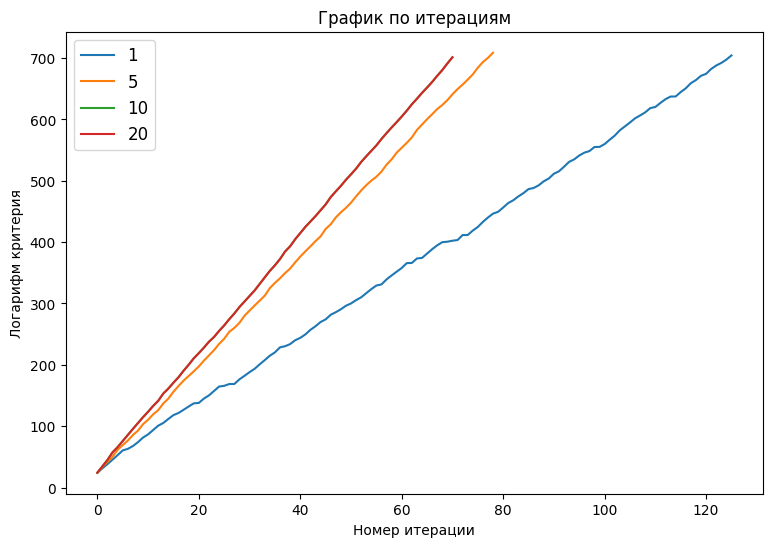

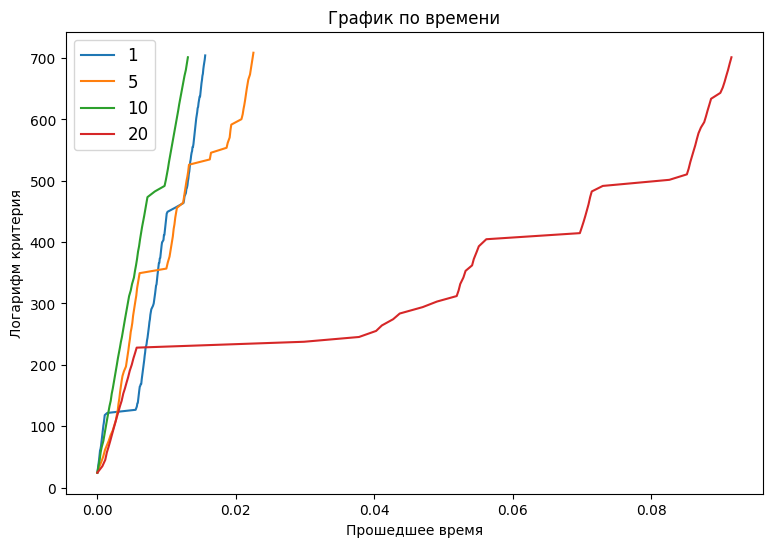

In [264]:
risovach(times=[times1, times5, times10, times20], errs=[errs1, errs5, errs10, errs10], labels=['1', '5', '10', '20'])

In [265]:
# если sample_type = 0, то выбор координат производится независимо
# sample_type = 1, выбор без повторений

def update_grad(g, x, b, sample_type):

        n = len(g)
        if sample_type == 0:
            for i in range(b):
                index = np.random.randint(low=0, high=n)
                g[index] = grad_i(x, i)
        
        if sample_type == 1:
            indexes = set()
            while len(indexes) < b:
                indexes.add(np.random.randint(low=0, high=n))
            for index in indexes:
                g[index] = grad_i(x, index)

        return g

def scd(x0, error=err_gradnorm, b=1, sample_type=0, iters=1000, eps=1e-9):
    
    x = x0
    x_vals = [x]
    f_vals = [f(x)]
    times = [0.]
    errs = [error(x)]

    start = time.time()
    g = grad(x)

    for i in range(1, iters):
        
        x = x - 1 / (4*L*d) * d * g
        g = update_grad(g, x, b, sample_type)

        x_vals.append(x)
        f_vals.append(f(x))
        times.append(time.time() - start)
        errs.append(error(x))

        if error(x) < eps:
            break

    return x_vals, f_vals, times, errs

In [266]:
#ответ

## Задача 2

Рассмотрим задачу линейной регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Оцените $\mu$ и $L$ для данной задачи. 

In [267]:
#ответ

__(б)__ Реализуйте координатный SGD, SEGA для задачи линейно регрессии. Каким будете брать $b$? Как будете выбирать шаг и другие параметры методов?

In [268]:
#ответ

__(в)__ Постройте графики сравнения всех методов: по оси $x$ используйте время или количество арифметических операций, по оси $y$ - $\|\nabla f(x^k)\|$ или точность на тесте. Таким образом, всего 4 графика. Сделайте сравнение и вывод.

In [269]:
#ответ

__Бонусные пункты__

__(г)__ Попробуйте объеденить подходы SAGA/SVRG/L-SVRG и координатный SGD/SEGA (т.е. могут получиться пары SAGA + координатный, SVRG + SEGA и еще четыре других). Вам достаточно выбрать одну пару. Как при этом будет выглядеть итерация метода (запишите в явном виде)? Докажите сходимость данного подхода для $\mu$-сильно выпуклой $f$ и $L$-гладкой $f_i$.

In [270]:
#ответ

__(д)__ Реализуйте новый метод. Сравните его с двумя методами, которые были взяты за базу, на задаче линейной регресии. Способы сравнения методов придумайте самостоятельно. Сделайте вывод.

In [271]:
#ответ